In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_df = pd.read_csv("data.csv", parse_dates=["Date"])

format_demand = lambda x: pd.to_numeric(str(x).strip("()"))

data_df["Order_Demand"] = [format_demand(x[1]["Order_Demand"]) for x in data_df.iterrows()]

formatted_df = data_df[data_df["Order_Demand"] != 0].dropna()
formatted_df = formatted_df.sort_values('Date')
formatted_df.reset_index(drop=True, inplace=True)

print(formatted_df.dtypes)

Product_Code                object
Warehouse                   object
Product_Category            object
Date                datetime64[ns]
Order_Demand                 int64
dtype: object


In [48]:
formatted_df.pivot_table(values="Order_Demand", index="Product_Category", aggfunc=["count", np.sum, np.mean, np.median, min, max])

,count,sum,mean,median,min,max
,Order_Demand,Order_Demand,Order_Demand,Order_Demand,Order_Demand,Order_Demand
Product_Category,,,,,,
Category_001,97431,1757473,18.038130,5,1,2075
Category_002,77,628,8.155844,4,1,60
Category_003,4131,392950,95.122246,32,1,1860
Category_004,327,99046,302.892966,200,1,2400
Category_005,101003,199674520,1976.916725,500,10,500000
Category_006,35262,405571330,11501.654189,3000,1,1000000
Category_007,81930,128691531,1570.749799,100,1,1144000
Category_008,1554,17568,11.305019,4,1,200


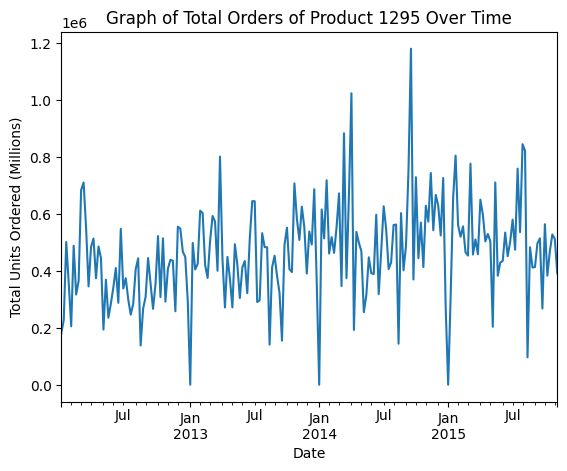

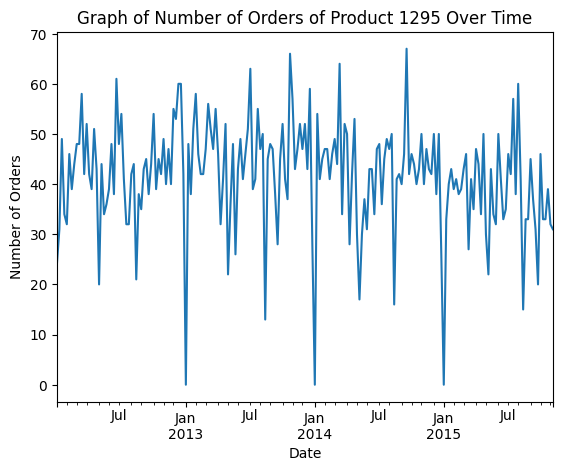

In [77]:
from sklearn.model_selection import train_test_split

DATA_FREQ = "W"
OVERLAY = "M"
POLY_REG = 16
RIDGE = 4

product1295_full = formatted_df[formatted_df["Product_Code"] == "Product_1295"]
product1295,product1295_test = train_test_split(product1295_full, test_size=0.2, shuffle=False)

product1295_pivot = product1295.pivot_table(values="Order_Demand", index="Date", aggfunc=[np.sum, "count"])

product1295_test_count = product1295_test.groupby(pd.Grouper(key="Date", freq=DATA_FREQ)).count().reset_index()
product1295_test_sum = product1295_test.groupby(pd.Grouper(key="Date", freq=DATA_FREQ)).sum().reset_index()
product1295_full_dates = product1295_full.groupby(pd.Grouper(key="Date", freq=DATA_FREQ)).sum().reset_index()

weekly_product1295 = product1295.groupby(pd.Grouper(key="Date", freq=DATA_FREQ)).sum().reset_index()
weekly_product1295.plot(x="Date", y="Order_Demand", kind="line", title="Graph of Total Orders of Product 1295 Over Time", legend=False)
plt.ylabel("Total Units Ordered (Millions)")

weeklyorder_product1295 = product1295.groupby(pd.Grouper(key="Date", freq=DATA_FREQ)).count().reset_index()
weeklyorder_product1295.plot(x="Date", y="Order_Demand", kind="line", title="Graph of Number of Orders of Product 1295 Over Time", legend=False)
plt.ylabel("Number of Orders")
plt.show()

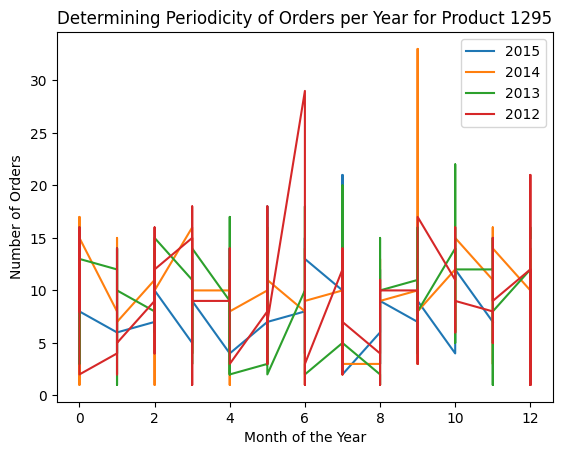

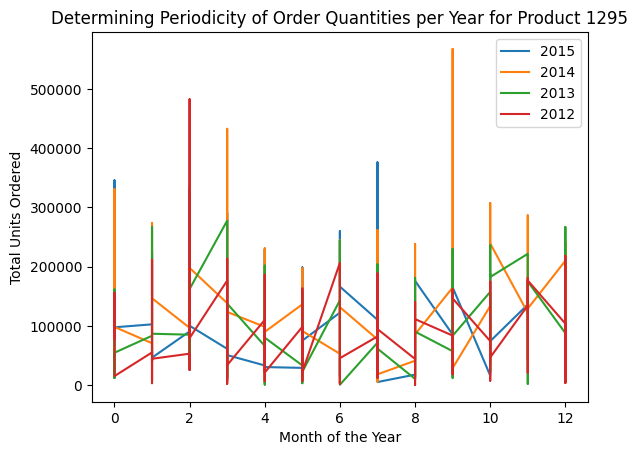

In [78]:
from datetime import datetime
import copy

times = {"D": 86400, "W": 86400 * 7 , "M": 86400 * 28, "Y": 86400 * 365 }

def dt_to_n(dt):
    dt_unix = dt.timestamp()
    year_unix = datetime(dt.year, 1, 1).timestamp()
    relative_unix = dt_unix - year_unix
    # TODO: Make this react to the DATA_FREQ value
    return relative_unix//times[OVERLAY]

prod1295 = copy.copy(product1295_pivot)
prod1295["days"] = [dt_to_n(i) for i,_ in prod1295.iterrows()]
prod1295["year"] = [i.year for i,_ in prod1295.iterrows()]

plt_2d = plt.figure().add_subplot()
plt.title("Determining Periodicity of Orders per Year for Product 1295")
plt.xlabel("Month of the Year")
plt.ylabel("Number of Orders")

plt_2d_sum = plt.figure().add_subplot()
plt.title("Determining Periodicity of Order Quantities per Year for Product 1295")
plt.xlabel("Month of the Year")
plt.ylabel("Total Units Ordered")

annual_data = prod1295.groupby("year")
i=0
t = len(annual_data)
for year, year_data in reversed(tuple(annual_data)):
    plt_2d.plot(year_data["days"], year_data[("count","Order_Demand")], label=year)
    plt_2d_sum.plot(year_data["days"], year_data[("sum","Order_Demand")], label=year)
    i+=1
    
plt_2d.legend()
plt_2d_sum.legend()
plt.show()

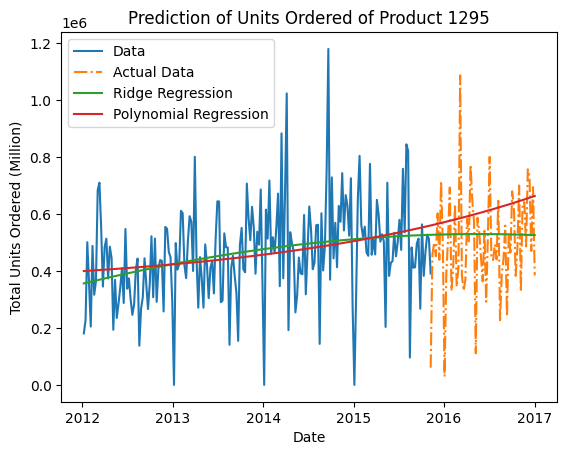

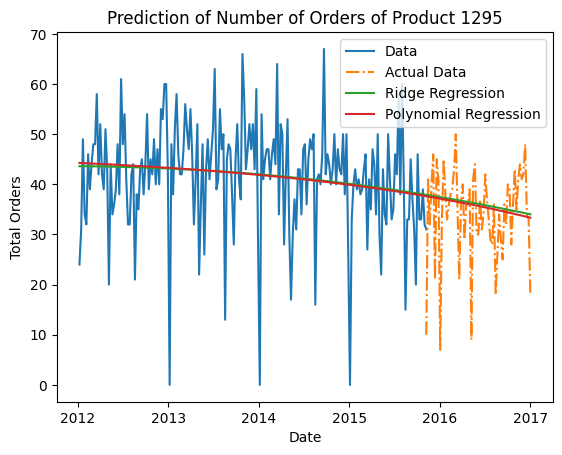

In [96]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline

product1295_full_datesX = product1295_full_dates["Date"].values.astype(np.int64)[:, np.newaxis]

order_quantity_model1295 = LinearRegression()
poly_features_1 = PolynomialFeatures(degree=POLY_REG, include_bias=False)
modelX_1 = weekly_product1295["Date"].values.astype(np.int64)[:, np.newaxis]
polyX_1 = poly_features_1.fit_transform(modelX_1)
order_quantity_model1295.fit(polyX_1, weekly_product1295["Order_Demand"])
polyX_new_1 = poly_features_1.transform(product1295_full_datesX)

ridge_reg_1 = Ridge(alpha=0.1, solver="sag", random_state=42)
ridge_reg_pipe_1 = Pipeline([
        ("poly_features", PolynomialFeatures(degree=RIDGE, include_bias=False)),
        ("std_scaler", StandardScaler()),
        ("regul_reg", ridge_reg_1),
    ])
ridge_reg_pipe_1.fit(modelX_1,weekly_product1295["Order_Demand"])

# Plot Validation Data on this graph
# Ridge and Poly_Reg X Dates need to be extended
# Sort out Axes - correct labels
# Chart Titles
# Create table comparing error of prediction vs actual result
# Ensemble the 2 predictions - Mean as the final value?

plt.plot(weekly_product1295["Date"], weekly_product1295["Order_Demand"], label="Data")
plt.plot(product1295_test_sum["Date"], product1295_test_sum["Order_Demand"], "-.", label="Actual Data")
plt.plot(product1295_full_dates["Date"], ridge_reg_pipe_1.predict(product1295_full_datesX), label="Ridge Regression")
plt.plot(product1295_full_dates["Date"], order_quantity_model1295.predict(polyX_new_1), label="Polynomial Regression")

plt.title("Prediction of Units Ordered of Product 1295")
plt.xlabel("Date")
plt.ylabel("Total Units Ordered (Million)")

plt.legend()
plt.show()


order_num_model1295 = LinearRegression()
poly_features_2 = PolynomialFeatures(degree=POLY_REG, include_bias=False)
modelX_2 = weeklyorder_product1295["Date"].values.astype(np.int64)[:, np.newaxis]
polyX_2 = poly_features_2.fit_transform(modelX_2)
order_num_model1295.fit(polyX_2, weeklyorder_product1295["Order_Demand"])
polyX_new_2 = poly_features_2.transform(product1295_full_datesX)

ridge_reg_2 = Ridge(alpha=0.5, solver="sag", random_state=42)
ridge_reg_pipe_2 = Pipeline([
        ("poly_features", PolynomialFeatures(degree=RIDGE, include_bias=False)),
        ("std_scaler", StandardScaler()),
        ("regul_reg", ridge_reg_2),
    ])
ridge_reg_pipe_2.fit(modelX_2,weeklyorder_product1295["Order_Demand"])


plt.plot(weeklyorder_product1295["Date"], weeklyorder_product1295["Order_Demand"], label="Data")
plt.plot(product1295_test_count["Date"], product1295_test_count["Order_Demand"], "-.", label="Actual Data")
plt.plot(product1295_full_dates["Date"], ridge_reg_pipe_2.predict(product1295_full_datesX), label="Ridge Regression")
plt.plot(product1295_full_dates["Date"], order_num_model1295.predict(polyX_new_2), label="Polynomial Regression")

plt.title("Prediction of Number of Orders of Product 1295")
plt.xlabel("Date")
plt.ylabel("Total Orders")

plt.legend()
plt.show()
plt.show()



In [112]:
test_valX_1 = product1295_test_sum["Date"].values.astype(np.int64)[:, np.newaxis]
test_polyX_1 = poly_features_1.transform(test_valX_1)

product1295_test_sum["Ridge_Values"] = ridge_reg_pipe_1.predict(test_valX_1)
product1295_test_sum["Ridge_Error"] = product1295_test_sum["Ridge_Values"] - product1295_test_sum["Order_Demand"]
product1295_test_sum["Ridge_Error^2"] = product1295_test_sum["Ridge_Error"] ** 2

product1295_test_sum["Poly_Values"] = order_quantity_model1295.predict(test_polyX_1)
product1295_test_sum["Poly_Error"] = product1295_test_sum["Poly_Values"] - product1295_test_sum["Order_Demand"]
product1295_test_sum["Poly_Error^2"] = product1295_test_sum["Poly_Error"] ** 2

prod1295_sum_poly_abs_err = product1295_test_sum["Poly_Error"].abs().mean()
prod1295_sum_ridge_abs_err = product1295_test_sum["Ridge_Error"].abs().mean()

prod1295_sum_poly_mse = product1295_test_sum["Poly_Error^2"].mean()
prod1295_sum_ridge_mse = product1295_test_sum["Ridge_Error^2"].mean()

print(f"Ridge MSE: {np.sqrt(prod1295_sum_ridge_mse)}")
print(f"Ridge Abs Err: {prod1295_sum_ridge_abs_err}\n")
print(f"Poly MSE: {np.sqrt(prod1295_sum_poly_mse)}")
print(f"Poly Abs Err: {prod1295_sum_poly_abs_err}")

product1295_test_sum[["Date", "Order_Demand", "Ridge_Values", "Ridge_Error", "Poly_Values", "Poly_Error"]].tail()

Ridge MSE: 183105.90292966584
Ridge Abs Err: 140322.52411026874

Poly MSE: 209652.51622006626
Poly Abs Err: 164683.91058208488


,Date,Order_Demand,Ridge_Values,Ridge_Error,Poly_Values,Poly_Error
56,2016-12-04,756900,526736.369701,-230163.630299,655004.704483,-101895.295517
57,2016-12-11,731300,526527.249196,-204772.750804,657022.932325,-74277.067675
58,2016-12-18,470200,526310.810719,56110.810719,659053.557465,188853.557465
59,2016-12-25,694200,526087.048137,-168112.951863,661096.650950,-33103.349050
60,2017-01-01,384300,525855.955315,141555.955315,663152.284205,278852.284205


In [98]:
test_valX_2 = product1295_test_count["Date"].values.astype(np.int64)[:, np.newaxis]
test_polyX_2 = poly_features_2.transform(test_valX_2)

product1295_test_count["Ridge_Values"] = ridge_reg_pipe_2.predict(test_valX_2)
product1295_test_count["Poly_Values"] = order_num_model1295.predict(test_polyX_2)

product1295_test_count[["Date", "Order_Demand", "Ridge_Values", "Poly_Values"]].tail()

,Date,Order_Demand,Ridge_Values,Poly_Values
56,2016-12-04,42,34.319309,33.682088
57,2016-12-11,48,34.246699,33.598416
58,2016-12-18,34,34.173787,33.514230
59,2016-12-25,33,34.100572,33.429527
60,2017-01-01,18,34.027053,33.344304


In [99]:
product_demand_pivot = formatted_df.pivot_table(values="Order_Demand", index="Product_Code", aggfunc=["count", np.sum])

order_quantity = product_demand_pivot.sort_values(by=("sum", "Order_Demand"), ascending=False)
order_quantity.head()

,count,sum
,Order_Demand,Order_Demand
Product_Code,,
Product_1359,16885,472474000
Product_1248,6323,289117000
Product_0083,1984,210651000
Product_1341,2659,169777000
Product_1295,10464,123303000


In [100]:
order_number = product_demand_pivot.sort_values(by=("count", "Order_Demand"), ascending=False)
order_number.head()

,count,sum
,Order_Demand,Order_Demand
Product_Code,,
Product_1359,16885,472474000
Product_1295,10464,123303000
Product_1378,9672,83632700
Product_0620,9391,56789
Product_1286,8804,101566400


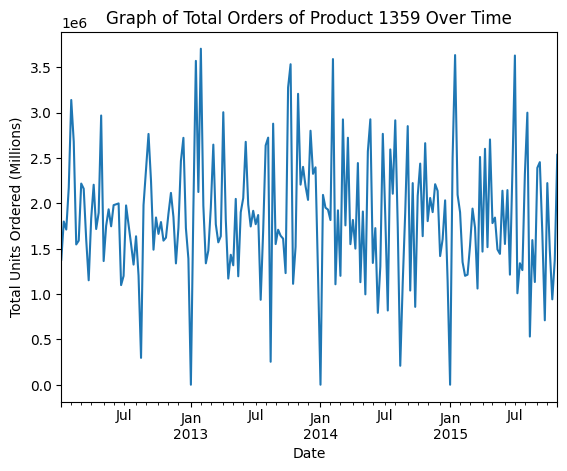

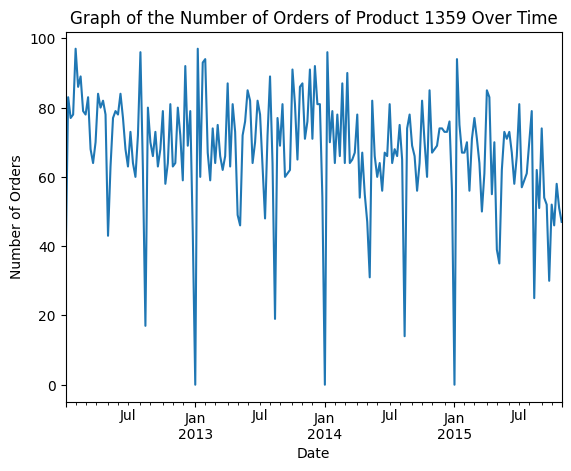

In [101]:
product1359_full = formatted_df[formatted_df["Product_Code"] == "Product_1359"]
product1359,product1359_test = train_test_split(product1359_full, test_size=0.2, shuffle=False)

product1359_test_count = product1359_test.groupby(pd.Grouper(key="Date", freq=DATA_FREQ)).count().reset_index()
product1359_test_sum = product1359_test.groupby(pd.Grouper(key="Date", freq=DATA_FREQ)).sum().reset_index()
product1359_full_dates = product1359_full.groupby(pd.Grouper(key="Date", freq=DATA_FREQ)).sum().reset_index()

weekly_product1359 = product1359.groupby(pd.Grouper(key="Date", freq=DATA_FREQ)).sum().reset_index()
weekly_product1359.plot(x="Date", y="Order_Demand", kind="line", title="Graph of Total Orders of Product 1359 Over Time", legend=False)
plt.ylabel("Total Units Ordered (Millions)")

weeklyorder_product1359 = product1359.groupby(pd.Grouper(key="Date", freq=DATA_FREQ)).count().reset_index()
weeklyorder_product1359.plot(x="Date", y="Order_Demand", kind="line", title="Graph of the Number of Orders of Product 1359 Over Time", legend=False)
plt.ylabel("Number of Orders")

plt.show()

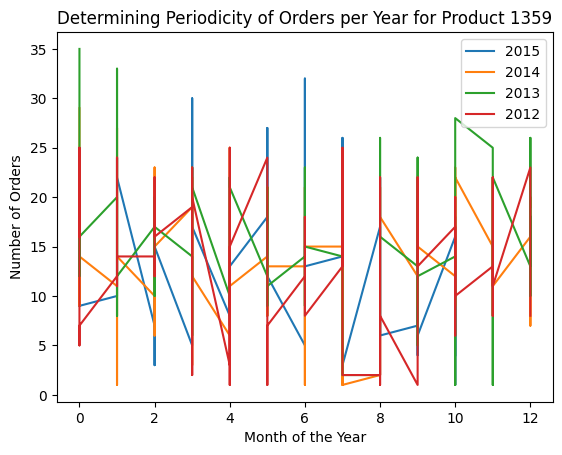

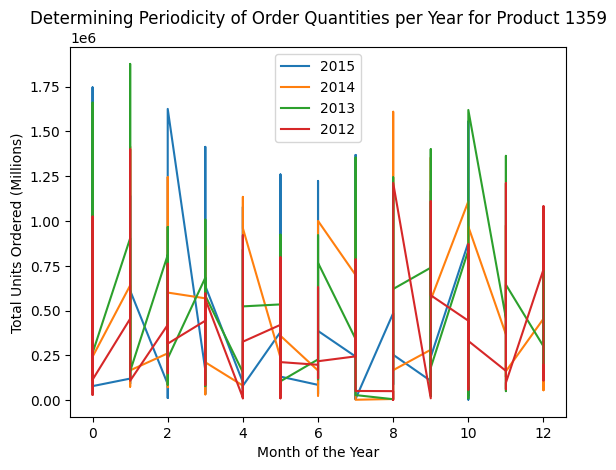

In [102]:
product1359_pivot = product1359.pivot_table(values="Order_Demand", index="Date", aggfunc=[np.sum, "count"])

prod1359 = copy.copy(product1359_pivot)
prod1359["days"] = [dt_to_n(i) for i,_ in prod1359.iterrows()]
prod1359["year"] = [i.year for i,_ in prod1359.iterrows()]

plt_2d = plt.figure().add_subplot()
plt.title("Determining Periodicity of Orders per Year for Product 1359")
plt.xlabel("Month of the Year")
plt.ylabel("Number of Orders")

plt_2d_sum = plt.figure().add_subplot()
plt.title("Determining Periodicity of Order Quantities per Year for Product 1359")
plt.xlabel("Month of the Year")
plt.ylabel("Total Units Ordered (Millions)")


annual_data = prod1359.groupby("year")
i=0
t = len(annual_data)
for year, year_data in reversed(tuple(annual_data)):
    plt_2d.plot(year_data["days"], year_data[("count","Order_Demand")], label=year)
    plt_2d_sum.plot(year_data["days"], year_data[("sum","Order_Demand")], label=year)
    i+=1
    
plt_2d.legend()
plt_2d_sum.legend()
plt.show()


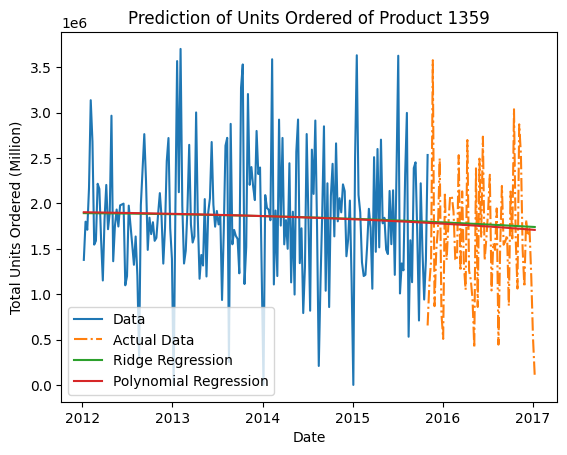

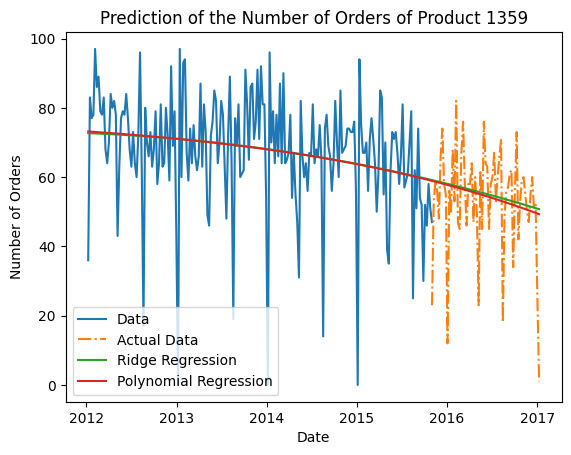

In [103]:
product1359_full_datesX = product1359_full_dates["Date"].values.astype(np.int64)[:, np.newaxis]

order_quantity_model1359 = LinearRegression()
poly_features_3 = PolynomialFeatures(degree=POLY_REG, include_bias=False)
modelX_3 = weekly_product1359["Date"].values.astype(np.int64)[:, np.newaxis]
polyX_3 = poly_features_3.fit_transform(modelX_3)
order_quantity_model1359.fit(polyX_3, weekly_product1359["Order_Demand"])
polyX_new_3 = poly_features_3.transform(product1359_full_datesX)

ridge_reg_3 = Ridge(alpha=1, solver="sag", random_state=42)
ridge_reg_pipe_3 = Pipeline([
        ("poly_features", PolynomialFeatures(degree=RIDGE, include_bias=False)),
        ("std_scaler", StandardScaler()),
        ("regul_reg", ridge_reg_3),
    ])
ridge_reg_pipe_3.fit(modelX_3,weekly_product1359["Order_Demand"])

plt.plot(weekly_product1359["Date"], weekly_product1359["Order_Demand"], label="Data")
plt.plot(product1359_test_sum["Date"], product1359_test_sum["Order_Demand"], "-.", label="Actual Data")
plt.plot(product1359_full_dates["Date"], ridge_reg_pipe_3.predict(product1359_full_datesX), label="Ridge Regression")
plt.plot(product1359_full_dates["Date"], order_quantity_model1359.predict(polyX_new_3), label="Polynomial Regression")

plt.title("Prediction of Units Ordered of Product 1359")
plt.xlabel("Date")
plt.ylabel("Total Units Ordered (Million)")

plt.legend()
plt.show()
plt.show()


order_num_model1359 = LinearRegression()
poly_features_4 = PolynomialFeatures(degree=POLY_REG, include_bias=False)
modelX_4 = weeklyorder_product1359["Date"].values.astype(np.int64)[:, np.newaxis]
polyX_4 = poly_features_4.fit_transform(modelX_4)
order_num_model1359.fit(polyX_4, weeklyorder_product1359["Order_Demand"])
polyX_new_4 = poly_features_4.transform(product1359_full_datesX)

ridge_reg_4 = Ridge(alpha=0.1, solver="sag", random_state=42)
ridge_reg_pipe_4 = Pipeline([
        ("poly_features", PolynomialFeatures(degree=RIDGE, include_bias=False)),
        ("std_scaler", StandardScaler()),
        ("regul_reg", ridge_reg_4),
    ])
ridge_reg_pipe_4.fit(modelX_4,weeklyorder_product1359["Order_Demand"])

plt.plot(weeklyorder_product1359["Date"], weeklyorder_product1359["Order_Demand"], label="Data")
plt.plot(product1359_test_count["Date"], product1359_test_count["Order_Demand"], "-.", label="Actual Data")
plt.plot(product1359_full_dates["Date"], ridge_reg_pipe_4.predict(product1359_full_datesX), label="Ridge Regression")
plt.plot(product1359_full_dates["Date"], order_num_model1359.predict(polyX_new_4), label="Polynomial Regression")

plt.title("Prediction of the Number of Orders of Product 1359")
plt.xlabel("Date")
plt.ylabel("Number of Orders")

plt.legend()
plt.show()
plt.show()

In [104]:
test_valX_3 = product1359_test_sum["Date"].values.astype(np.int64)[:, np.newaxis]
test_polyX_3 = poly_features_3.transform(test_valX_3)

product1359_test_sum["Ridge_Values"] = ridge_reg_pipe_3.predict(test_valX_3)
product1359_test_sum["Poly_Values"] = order_quantity_model1359.predict(test_polyX_3)

product1359_test_sum[["Date", "Order_Demand", "Ridge_Values", "Poly_Values"]].tail()

,Date,Order_Demand,Ridge_Values,Poly_Values
58,2016-12-11,1644000,1.744812e+06,1.714477e+06
59,2016-12-18,1717000,1.743769e+06,1.712988e+06
60,2016-12-25,1189000,1.742722e+06,1.711489e+06
61,2017-01-01,516000,1.741671e+06,1.709981e+06
62,2017-01-08,100000,1.740617e+06,1.708464e+06


In [105]:
test_valX_4 = product1359_test_count["Date"].values.astype(np.int64)[:, np.newaxis]
test_polyX_4 = poly_features_4.transform(test_valX_4)

product1359_test_count["Ridge_Values"] = ridge_reg_pipe_4.predict(test_valX_4)
product1359_test_count["Poly_Values"] = order_num_model1359.predict(test_polyX_4)

product1359_test_count[["Date", "Order_Demand", "Ridge_Values", "Poly_Values"]].tail()

,Date,Order_Demand,Ridge_Values,Poly_Values
58,2016-12-11,60,51.346453,50.037613
59,2016-12-18,51,51.195661,49.854993
60,2016-12-25,52,51.044307,49.671251
61,2017-01-01,25,50.892389,49.486381
62,2017-01-08,1,50.739907,49.300378
